In [34]:
import os
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision import transforms
from torchvision.models import ResNet152_Weights

In [2]:
def resize(img, target_size=256):
    w, h = img.size
    ratio = target_size / h if w > h else target_size / w
    return img.resize((int(w*ratio), int(h*ratio)))


hyperparams = {
    "train_val_ratio" : 0.9,
    "batch_size" : 80,
    "learning_rate" : 0.0001,
    "epochs" : 5,
    "transform" : transforms.Compose(
        [
            transforms.Lambda(resize),
            # transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0/255.0, 1.0/255.0, 1.0/255.0]
            )
        ]
    )
}

dataset = ImageFolder("./data/train", transform=hyperparams["transform"])

# Train, Val 데이터 분리
train_size = int(len(dataset) * hyperparams["train_val_ratio"])
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Train, Val 데이터 로더 정의
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True
)

model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))

model_path = "./models/rock_latest.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("model param load")

model param load


## 모델 학습

In [12]:
from torch.amp import autocast, GradScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])
scaler = GradScaler() 

for epoch in range(hyperparams["epochs"]):
    cost = 0.0
    model.train()

    for img, cls in train_dataloader:
        img = img.to(device)
        cls = cls.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"): 
            output = model(img)
            loss = criterion(output, cls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        cost += loss.item()

    cost = cost / len(train_dataloader)

    # 모델 검증
    with torch.no_grad():
        model.eval()
        acc = 0.0

        for img, cls in val_dataloader:
            img = img.to(device)
            cls = cls.to(device)

            with autocast(device_type="cuda"):
                outputs = model(img)
                probs = F.softmax(outputs, dim=-1)
                outputs_classes = torch.argmax(probs, dim=-1)

            acc += int(torch.eq(cls, outputs_classes).sum())

        total = len(val_dataloader) * hyperparams['batch_size']
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}, acc@1 : {acc / total * 100:.2f}")

    # 모델 저장
    if os.path.exists(model_path):
        os.remove(model_path)
    torch.save(model.state_dict(), model_path)


cuda
Epoch :    1, Cost : 0.192, acc@1 : 95.98
Epoch :    2, Cost : 0.185, acc@1 : 95.85


KeyboardInterrupt: 

## 모델 추론

In [13]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd

# 모델 로드
model = models.resnet152()
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.eval().cuda()

# 전처리 정의
transform = transforms.Compose([
    transforms.Lambda(resize),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48235, 0.45882, 0.40784],
        std=[1.0 / 255.0, 1.0 / 255.0, 1.0 / 255.0]
    )
])

# 테스트 이미지 로드
test_dir = "./data/test"
image_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".jpg")])

# 배치 추론 설정
batch_size = 64
results = []
batch_images = []
batch_names = []

for i, fname in enumerate(image_files):
    path = os.path.join(test_dir, fname)
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img)
    batch_images.append(img_tensor)
    batch_names.append(fname)

    # 배치 단위로 추론하거나 마지막 남은 이미지들 처리
    if len(batch_images) == batch_size or i == len(image_files) - 1:
        input_tensor = torch.stack(batch_images).cuda()
        with torch.no_grad():
            outputs = model(input_tensor)
            preds = torch.argmax(outputs, dim=1).tolist()

        for name, pred in zip(batch_names, preds):
            image_id = os.path.splitext(name)[0]
            pred_label = dataset.classes[pred]
            results.append((image_id, pred_label))

        # 배치 초기화
        batch_images.clear()
        batch_names.clear()

# 결과 저장
df = pd.DataFrame(results, columns=["ID", "rock_type"])
sub_path = "./data/rock_submission.csv"
if os.path.exists(sub_path):
    os.remove(sub_path)
df.to_csv(sub_path, index=False)


## CAM 확인

model param load


100%|██████████| 64/64 [00:08<00:00,  7.66it/s]


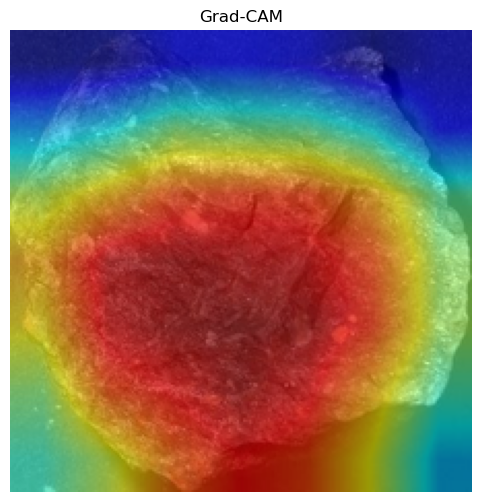

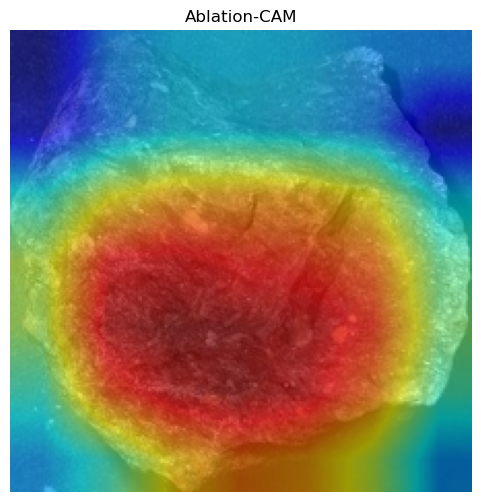

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import models
from PIL import Image
from torchvision import transforms

from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet152(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device).eval()
model_path = "./models/rock_latest.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("model param load")

transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

image = Image.open("./data/train/Andesite/TRAIN_01110.jpg")
input_tensor  = transforms(image).unsqueeze(0).to(device)

# 자동으로 Top-1 예측 class 사용
output = model(input_tensor)
top_class = output.argmax(dim=1).item()

# CAM 시각화를 위한 RGB 원본 이미지 (0~1, float32, numpy)
rgb_image = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# 타겟 레이어 및 클래스 지정
target_layer = model.layer4[-1]
targets = [ClassifierOutputTarget(top_class)] 

# Grad-CAM
cam_grad = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam_grad = cam_grad(input_tensor=input_tensor, targets=targets)[0]
visual_grad = show_cam_on_image(rgb_image, grayscale_cam_grad, use_rgb=True)

# Ablation-CAM
cam_ablation = AblationCAM(model=model, target_layers=[target_layer])
grayscale_cam_ablation = cam_ablation(input_tensor=input_tensor, targets=targets)[0]
visual_ablation = show_cam_on_image(rgb_image, grayscale_cam_ablation, use_rgb=True)

# 시각화 함수
def show_cam(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Grad-CAM 시각화
show_cam("Grad-CAM", visual_grad)

# Ablation-CAM 시각화
show_cam("Ablation-CAM", visual_ablation)